# Unit 6. Essential Deep Learning Tips & Tricks

# Exercise 1: Learning Rate Warmup

In [3]:
%load_ext watermark
%watermark -p torch,lightning,pl_bolts --conda

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
torch    : 2.2.2
lightning: 2.2.1
pl_bolts : not installed

conda environment: n/a



In [4]:
import lightning as L
import torch
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger

from shared_utilities import CustomDataModule, PyTorchMLP

In [5]:
num_epochs = 100

## Cosine annealing with 1-cycle schedule

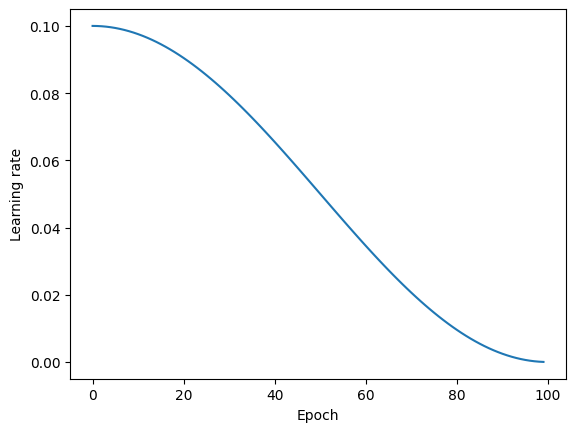

In [6]:
import matplotlib.pyplot as plt

model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
lrs = []

for i in range(num_epochs):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.ylabel("Learning rate")
plt.xlabel("Epoch")
plt.plot(lrs)
#plt.savefig("cosine-1cycle-epoch.pdf")
plt.show()

In [7]:
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR


model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = LinearWarmupCosineAnnealingLR(
    optimizer,
    warmup_epochs=num_epochs*0.25,
    max_epochs=num_epochs,
    warmup_start_lr=0.0)

lrs = []

for i in range(num_epochs):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.ylabel("Learning rate")
plt.xlabel("Epoch")
plt.plot(lrs)
#plt.savefig("cosine-1cycle-epoch.pdf")
plt.show()

ImportError: cannot import name 'LightningLoggerBase' from 'pytorch_lightning.loggers' (c:\Users\Harsh Vora\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\loggers\__init__.py)

In [ ]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate, num_epochs):  # New!
        super().__init__()

        self.learning_rate = learning_rate
        self.num_epochs = num_epochs  # New!
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self): # New! 
        opt = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        sch = LinearWarmupCosineAnnealingLR(
            opt, 
            warmup_epochs=self.num_epochs*0.25, 
            max_epochs=self.num_epochs,
            warmup_start_lr=0.0)

        return {
            "optimizer": opt,
            "lr_scheduler": {
                "scheduler": sch,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

In [ ]:
L.seed_everything(123)
dm = CustomDataModule()

pytorch_model = PyTorchMLP(num_features=100, num_classes=2)
lightning_model = LightningModel(
    model=pytorch_model,
    learning_rate=0.1,
    num_epochs=num_epochs) # New!

trainer = L.Trainer(
    max_epochs=num_epochs,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

Global seed set to 123
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebastianraschka/miniforge3/envs/dl-fundamentals/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [ ]:
trainer.fit(model=lightning_model, datamodule=dm)

/Users/sebastianraschka/miniforge3/envs/dl-fundamentals/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/my-model/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/var/folders/cb/1y0v6fzx5c54sztp5nqq39jc0000gn/T/ipykernel_15183/3563877523.py:50: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  sch = LinearWarmupCosineAnnealingLR(

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 15.3 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0   

Sanity Checking: 0it [00:00, ?it/s]

/Users/sebastianraschka/miniforge3/envs/dl-fundamentals/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/sebastianraschka/miniforge3/envs/dl-fundamentals/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

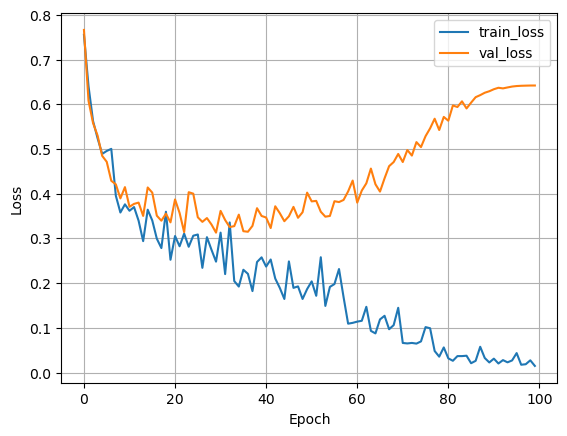

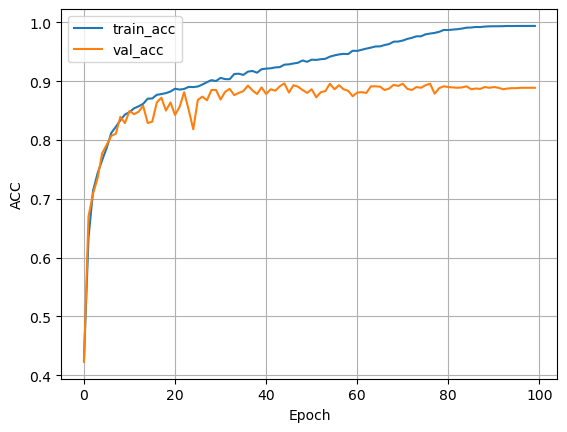

In [ ]:
### Plot
import matplotlib.pyplot as plt
import pandas as pd

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

plt.savefig("suggest_loss.pdf")

df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.savefig("suggest_acc.pdf")

plt.show()

In [ ]:
trainer.test(model=lightning_model, datamodule=dm)

/Users/sebastianraschka/miniforge3/envs/dl-fundamentals/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.890749990940094     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.890749990940094}]